In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv('./data/구석구석_서울크롤링_4057.csv')

In [2]:
# 사용할 컬럼 선별
use_col = ['장소명', '상세설명','한줄설명', '리뷰','대표메뉴','취급메뉴', '주소']

# 전체 컬럼 중 사용할 컬럼이 아니면 제거
df.drop(set(df.columns) - set(use_col), axis=1, inplace=True)

In [3]:
# 주소 결측치 제거
df.drop(index=2665, inplace=True)

# index 재설정
df.reset_index(drop='index', inplace=True)

# null 값 공백으로 치환
df.fillna('', inplace=True)

In [4]:
from konlpy.tag import Komoran
import re
ko = Komoran()

for col in use_col[1:]:
    for row, text in enumerate(df[col]):
        # 이모지, 특수문자 제거
        token = ko.nouns(re.sub('[^A-Za-z0-9가-힣]', ' ', text))

        # 정제된 토큰들로 다시 문장화
        df.loc[row, col] = " ".join(token)

In [5]:
# 사용할 컬럼들의 모든 text를 이어 붙일 '정보' 컬럼 생성
df['정보'] = df['장소명'] + " "

for i in use_col[1:] :
    df.정보 += df[i]

# 장소명과 정보 컬럼을 제외한 나머지 컬럼 삭제
df.drop(use_col[1:], axis=1, inplace=True)

### 불용어 제거

In [250]:
# 불용어
stop_word = [
    ' ',',','.','등','수','이요','요','번','앞','곳','집','류','모','봉','돌','호선','객','부','콩','겸','그','위','계','무','안','눈','방','이','팅',
    '비','통','석','개','세','순','외','점','전','것','두','나','옥','내','역','과','뿐','이류','찰','더','여','년','로','층','차','종','배','중','몽',
    '도','날','널','때','꼭','및','볼','후','룸','의','실','또','제','온','를','터','인','탕','총','각','명','저','리','처','존','뜻','이자','움','입',
    '게','좀','데','기','만','용','초','몸','핫','거','넉','끼','단','접','호','창','난','칸','스','또한','듯','때문','린','오','시','은','함','적','샷',
    '이후','마치','가도','원','임','이제','얼마','밍','재','란','송','거나','구','중이','늘','감','앤','변','목','대해','근대','운','널리','곳도','가끔',
    '주','걸','장','상','이외','통해','얼','유','사','도량','갓','너','고기구','깃','어','반','하면 된다','파',''
]

In [7]:
# 불용어 제거
for i in range(len(df)) :
    temp = [word for word in df.정보[i].split(' ') if word not in stop_word]
    df.loc[i, '정보'] = ' '.join(temp)

## TF-IDF

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# TF-IDF 벡터화
tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(df['정보'])

In [9]:
import pickle

# 모델 저장
with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf, f)

----

## 출력

In [324]:
# 사용자의 입력문장을 통한 코사인 유사도 계산
def user_input_to_cosine_sim(model, query) :
    query = ' '.join(ko.nouns(query))
    query_tfidf = model.transform([query])
    cosine_sim = cosine_similarity(query_tfidf, tfidf_matrix).reshape(-1)
    return cosine_sim

# 장소명을 입력받아 그 장소명의 정보 추출
def searchByName(place_name) :
    # 찾을 정보의 df
    find_df = pd.read_csv("./data/구석구석_서울_크롤링_imageurl.csv")
    json_col = ["장소명", "주소", "상세설명", "문의 및 안내", "사진주소"]

    # temp_dict = find_df.loc[find_df.장소명 == place_name, json_col].fillna("정보 없음").iloc[0].to_dict()
    temp_df = find_df.loc[(find_df.장소명 == place_name), json_col].fillna("정보 없음")
    temp_df.columns = ["name", "address", "description", "inquieries", "imageName"]

    return temp_df.iloc[0].to_dict()

# 저장된 모델 불러오기
with open('./tfidf_vectorizer.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

# 사용자가 입력한 문장
input_sentence = "경복궁 돼지국밥"


result_cosine_similarity = user_input_to_cosine_sim(loaded_model, input_sentence)
top_index = np.argsort(result_cosine_similarity)[::-1]

result_arr = []

for row in top_index[:10]:
    if result_cosine_similarity[row] <= 0 :
        break
    name = df.loc[row, '장소명']
    result_arr.append(searchByName(name))

In [325]:
result_arr

[{'name': '경복궁',
  'address': '서울특별시 종로구 사직로 161',
  'description': '경복궁은 1395년 태조 이성계에 의해서 새로운 조선왕조의 법궁으로 지어졌다. 경복궁은 동궐(창덕궁)이나 서궐(경희궁)에 비해 위치가 북쪽에 있어 ‘북궐’이라 불리기도 했다. 경복궁은 5대 궁궐 가운데 으뜸의 규모와 건축미를 자랑한다. 경복궁 근정전에서 즉위식을 가진 왕들을 보면 제2대 정종, 제4대 세종, 제6대 단종, 제7대 세조, 제9대 성종, 제11대 중종, 제13대 명종 등이다. 경복궁은 임진왜란 때 상당수의 건물이 불타 없어진 아픔을 갖고 있으며, 고종 때에 흥선대원군의 주도 아래 7,700여 칸에 이르는 건물들을 다시 세웠다. 그러나 또다시 명성황후 시해사건이 일어나면서 왕조의 몰락과 함께 경복궁도 왕궁으로서의 기능을 상실하고 말았다. 경복궁에는 조선시대의 대표적인 건축물인 경회루와 향원정의 연못이 원형대로 남아 있으며, 근정전의 월대와 조각상들은 당시의 조각미술을 대표한다. 현재 흥례문 밖 서편에는 국립고궁 박물관이 위치하고 있고, 경복궁 내 향원정의 동편에는 국립민속 박물관이 위치하고 있다.\n\n* 주요 문화재\n1) 사적 경복궁\n2) 국보 경복궁 근정전\n3) 국보 경복궁 경회루\n4) 보물 경복궁 자경전\n5) 보물 경복궁 자경전 십장생 굴뚝\n6) 보물 경복궁 아미산굴뚝\n7) 보물 경복궁 근정문 및 행각\n8) 보물 경복궁 풍기대',
  'inquieries': '경복궁 관리소 02-3700-3900',
  'imageName': 'https://cdn.visitkorea.or.kr/img/call?cmd=VIEW&id=f0415f1b-c707-4214-aa80-bed323a22c02'},
 {'name': '광화문국밥',
  'address': '서울특별시 중구 세종대로21길 53',
  'description': '지하철 3호선 광화문역 6번 출구에서 도보 5분 거리에 있는 국밥 전문점이다. 돼지국밥이 대표메

In [318]:
# df의 모든 정보를 return
def find_all_info() :
    find_df = pd.read_csv("./data/구석구석_서울_크롤링_imageurl.csv")
    json_col = ["장소명", "주소", "상세설명", "문의 및 안내", "사진주소"]

    temp_df = find_df.loc[:, json_col].fillna("정보 없음")
    temp_df.columns = ["name", "address", "description", "inquiries", "imageName"]

    result_arr = []
    for i in range(len(temp_df)) :
        result_arr.append(temp_df.iloc[i,:].to_dict())

    return result_arr

----

In [308]:
count = 0
while True :
    result_bool = (result_cosine_similarity[top_index] > 0)[count]
    if ~result_bool :
        break
    count += 1
print(count)

4


In [309]:
result_cosine_similarity[top_index[:4]]

array([0.18908819, 0.14475038, 0.14055615, 0.13305637])

In [12]:
result_arr

[{'name': '라온석갈비',
  'address': '서울특별시 성동구 성수이로 119',
  'description': '오랫동안 석갈비에 노하우를 담아 온 라온 석갈비는 1, 2차 저온 양념숙성으로 부드러운 육질과 수제소스 진한 양념맛의 직화갈비가 유명한 곳이다. 석갈비는 평일 점심에만 먹을 수 있다. 라온 석갈비의 새로운 메뉴인 꽃갈비와 양념갈비는 가장 좋은 부위를 선별하여 직접 손질하고 숙성시켜 육즙이 풍부하다. 이외에도 한우꽃등심, 한돈양념갈비, 모듬수육, 통낙지볶음 등의 메뉴도 있다.',
  'inquieries': '0507-1438-1616',
  'imageName': 'https://cdn.visitkorea.or.kr/img/call?cmd=VIEW&id=e59d2541-4113-4800-83ff-0f697d292035'},
 {'name': '노란상 소갈비 본점',
  'address': '서울특별시 강남구 선릉로131길 22',
  'description': '강남구청역 3번출구 인근에 위치한 노란상소갈비 본점은 소갈비 전문점이다. 대표메뉴는 소금베이스의 양념으로 담백함과 은은한 단맛이 일품인 정갈비이다. 갈비의 가장 좋은 6, 7, 8번 만을 선별하여 수제로 칼집을 넣은 생갈비, 전통적인 양념갈비인 이동갈비, 당일 준비된 수량에 한하여 판매하는 토시살 등도 있다.',
  'inquieries': '02-543-9290',
  'imageName': 'https://cdn.visitkorea.or.kr/img/call?cmd=VIEW&id=94bed454-3e4e-4453-8329-85e3cf6746ce'},
 {'name': '홍능갈비집본점',
  'address': '서울특별시 동대문구 제기로 85',
  'description': '갈비명가 흥능갈비집 본점은 서울특별시 동대문구 청량리동에 있다. 대중교통을 이용할 경우 6호선 고려대역 4번 출구와 가장 가깝다. 60년에 가까운 전통 맛집답게 요즘은 볼 수 없는 네온사인 간판이 

In [88]:
cosine_result = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [127]:
search_index = df[df.장소명 == "호원아트홀"].index[0]

In [128]:
result_idx = np.argsort(cosine_result[search_index])[::-1]

In [129]:
result_idx = result_idx[:6]

df.loc[result_idx, ]

,장소명,정보
2300,호원아트홀,호원아트홀 아트 홀 호원대학교 취업 지원 센터 건물 위치 공연장 이다 극장 극장 스...
2462,아트센터 K,아트센터 K 아트 센터 형식 가치 차별 공연 예술 프로그램 소개 전문 공연장 이다 ...
3470,강동아트센터,강동아트센터 강동아트센터 강동구 명일 근 공원 위치 전문 공연장 자연 공원 문화 공...
2864,드림아트센터,드림아트센터 드림 아트 센터 꿈 예술 공간 신축 뮤지컬 연극 공연장 구비 극장 특유...
3384,아트홀 봄,아트홀 봄 아트 홀 봄 개관 서울특별시 산하 여성 복합 시설 서울 여성 플라자 문화...
3383,남산예술센터,남산예술센터 2009년 9월 서울시 창작 공간 개관 남산 예술 센터 창작 초연 중심...


In [130]:
cosine_result[search_index][result_idx]

array([1.        , 0.32960281, 0.30770052, 0.29544794, 0.25174418,
       0.24471321])

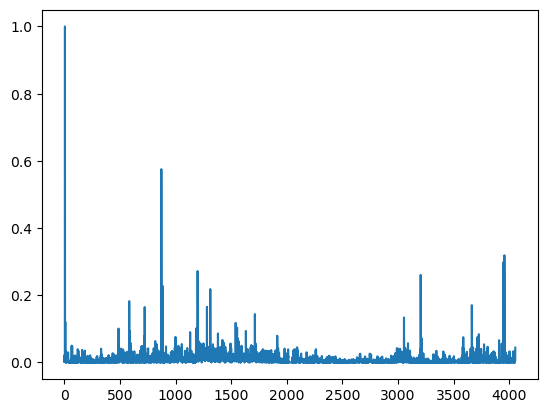

In [64]:
import matplotlib.pyplot as plt
plt.plot(cosine_result[5])

plt.show()

In [134]:
df.정보[3]

'친구네정육식당 보라매역 인근 위치 성비 고기 전문 정육 식당 맛집 고기 합리 가격 인분 제공 소문 인근 기업 회식 명소 각광 소 마리 돼지 마리 부위 선택 주문 판 가운데 된장찌개 파 채 양파 소스 마카로니 샐러드 기본 부족 반찬 관리 셀프 바 편리돼지 마리돼지 마리 소한 마리 삼겹살 외서울특별시 동작구 여의대방로 26 길'

In [260]:
find_df = pd.read_csv("./data/구석구석 정제.csv")
sentence = find_df.description[1000]
sentence

'부암동 몽유도원 도이창은 서울특별시 종로구 부암동, 서울미술관 옆에 있는 카페이다. 매장은 단독 건물로 되어있고 자체 주차장을 갖고 있어 주차가 편리하다. 넓은 홀에 테이블 사이가 넓어 여유 있고 날씨가 좋은 날엔 야외 테이블이 인기다. 공정무역을 통한 커피만을 고집하며 사회적 가치를 실현하고 있다. 대표 메뉴로 스페셜티 커피 오리지널이 있고 그 외 에스프레소, 핸드드립, 빈, 티, 주스와 함께 다양한 케이크와 디저트가 많다. 주변에 유금와당박물관, 석파정 서울미술관 등 박물관과 미술관이 많아 방문 전후에 둘러보기 좋다.'

In [264]:
one_stopword = []
for idx in range(len(find_df)) :
    sentence = find_df.description[idx]
    for word in [i for i in ko.nouns(sentence) if i not in stop_word] :
        if len(word) == 1 :
            one_stopword.append(word)

In [268]:
one_stopword = list(set(one_stopword))

In [274]:
[i for i in ko.nouns(sentence) if i not in stop_word + one_stopword]

['메뉴',
 '외부',
 '가공',
 '가공',
 '식자',
 '재가',
 '품질',
 '최고',
 '자재',
 '주방',
 '조리',
 '메뉴',
 '구성은',
 '고기',
 '피타',
 '형식',
 '전채',
 '요리',
 '중심',
 '메뉴',
 '구성',
 '전채',
 '요리',
 '부담',
 '편안',
 '요리',
 '위주',
 '서비스',
 '기존',
 '메인',
 '메뉴',
 '보조',
 '반찬',
 '개념',
 '반찬',
 '요리',
 '개념',
 '정성',
 '준비',
 '건강',
 '균형',
 '식단',
 '채소',
 '해산물',
 '고기',
 '중심',
 '구성',
 '재료',
 '천연',
 '양념',
 '제조',
 '자연',
 '친화',
 '소스',
 '요리',
 '조리',
 '고객',
 '건강',
 '생각',
 '서울시',
 '인증',
 '안심',
 '먹을거리',
 '자재',
 '사용',
 '고객',
 '단체',
 '연회장',
 '각종',
 '모임',
 '직장',
 '회식',
 '가족',
 '모임',
 '대형',
 '테이블',
 '구성']

In [269]:
[i for i in ko.nouns(sentence) if i not in one_stopword]

['메뉴',
 '외부',
 '가공',
 '가공',
 '식자',
 '재가',
 '품질',
 '최고',
 '자재',
 '주방',
 '조리',
 '메뉴',
 '구성은',
 '고기',
 '전',
 '피타',
 '이',
 '형식',
 '전채',
 '요리',
 '중심',
 '메뉴',
 '구성',
 '전채',
 '요리',
 '위',
 '부담',
 '편안',
 '수',
 '요리',
 '위주',
 '서비스',
 '기존',
 '메인',
 '메뉴',
 '보조',
 '반찬',
 '개념',
 '반찬',
 '요리',
 '개념',
 '정성',
 '준비',
 '건강',
 '균형',
 '식단',
 '채소',
 '해산물',
 '고기',
 '중심',
 '구성',
 '재료',
 '천연',
 '양념',
 '제조',
 '자연',
 '친화',
 '소스',
 '요리',
 '조리',
 '고객',
 '건강',
 '생각',
 '서울시',
 '인증',
 '안심',
 '먹을거리',
 '자재',
 '사용',
 '고객',
 '석',
 '단체',
 '연회장',
 '룸',
 '각종',
 '모임',
 '직장',
 '회식',
 '가족',
 '모임',
 '수',
 '대형',
 '석',
 '석',
 '테이블',
 '룸',
 '구성']